In [45]:
import pandas as pd
from model.comment import Comment
from model.user import User
from datetime import datetime
from tqdm import tqdm
from copy import deepcopy
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import joblib

In [46]:
df = pd.read_csv('../data/comments.csv')

In [47]:
df.head()

,by,id,kids,parent,text,time,type,deleted,dead
0,brenden2,22719825.0,{},22719170.0,"Get in line Saudis, there are a lot of people ...",2020-03-29 17:36:34,comment,NaN,NaN
1,aussieguy1234,22724106.0,{},22719170.0,Looks like as long as the victims stop using t...,2020-03-30 02:31:48,comment,NaN,NaN
2,nyolfen,22719715.0,"[22720774, 22719866]",22719170.0,how granular is ss7 psl data? if it's decades ...,2020-03-29 17:23:20,comment,NaN,NaN
3,flerchin,22724311.0,{},22719170.0,Oddly specific use-case. This only tracks the ...,2020-03-30 03:08:13,comment,NaN,NaN
4,chirau,22723796.0,[22724399],22719170.0,What is the issue here? Does the US not spy on...,2020-03-30 01:43:47,comment,NaN,NaN


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361930 entries, 0 to 361929
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   by       353099 non-null  object 
 1   id       361929 non-null  float64
 2   kids     302779 non-null  object 
 3   parent   361929 non-null  float64
 4   text     353085 non-null  object 
 5   time     361929 non-null  object 
 6   type     361929 non-null  object 
 7   deleted  8830 non-null    object 
 8   dead     9705 non-null    object 
dtypes: float64(2), object(7)
memory usage: 24.9+ MB


In [49]:
len(df['by'].unique())

60053

In [50]:
len(df['id'].unique())

356142

In [51]:
def row_to_comment(row):

    kids = []
    if row['kids'] != '{}' and type(row['kids']) == str:
        kids = list(map(int, row['kids'][1:-1].split(', ')))

    return Comment(
        by_id=row['by'],
        id=int(row['id']),
        parent_id=int(row['parent']),
        kids_ids=kids,
        text=row['text'],
        time=datetime.strptime(row['time'], '%Y-%m-%d %H:%M:%S'),
        type=row['type'],
        by=None,
        parent=None,
        kids=[]
    )

In [52]:
def row_to_user(row):

    return User(
        name=row['by'],
        comments_ids=[],
        comments=[]
    )

In [53]:
users = {}
comments = {}

for row_id in tqdm(range(len(df))):
    row = df.iloc[row_id]

    try:
        if row['by'] != '' and type(row['by']) == str:

            #add comment
            next_comment = row_to_comment(row)
            if next_comment.id in comments:
                # print(row)
                pass
            else:
                comments[next_comment.id] = next_comment

            #add user and comment to user
            next_user = row_to_user(row)
            if next_user.name not in users:
                users[next_user.name] = next_user
            users[next_user.name].comments_ids.append(next_comment.id)
            users[next_user.name].comments.append(next_comment)

    except Exception as e:
        print(e)
        print(row)

 84%|████████▎ | 302506/361930 [01:04<00:15, 3898.14it/s]time data '2020-01-11' does not match format '%Y-%m-%d %H:%M:%S'
by                                                   pledess
id                                               2.20165e+07
kids                          [22016789, 22017555, 22016569]
parent                                           2.20151e+07
text       > Epstein was joined by one or two female assi...
time                                              2020-01-11
type                                                 comment
deleted                                                  NaN
dead                                                     NaN
Name: 301900, dtype: object
 97%|█████████▋| 349624/361930 [01:12<00:02, 5320.06it/s]time data '2020-01-05' does not match format '%Y-%m-%d %H:%M:%S'
by                                                    jayd16
id                                               2.19582e+07
kids                                              [219583

In [54]:
len(users)

60052

In [55]:
len(comments)

347318

In [56]:
def create_empty_comment(id):
    return Comment(
        id=id,
        by_id=None,
        parent_id=None,
        kids_ids=None,
        text=None,
        time=None,
        type=None,
        by=None,
        parent=None,
        kids=None
    )

In [57]:
# fill by, parent, kids fields in comments
# if comment not found in comments create that object
current_comments_list = deepcopy(list(comments.values()))

for comment in tqdm(current_comments_list):

    try:

        comments[comment.id].by = users[comment.by_id]

        if comment.parent_id not in comments:
            # comments[comment.parent_id] = create_empty_comment(comment.parent_id)
            comments[comment.parent_id] = Comment(
                id=comment.parent_id,
                by_id=None,
                parent_id=None,
                kids_ids=[comment.id],
                text=None,
                time=None,
                type=None,
                by=None,
                parent=None,
                kids=[comment]
            )
        elif comment.id not in comments[comment.parent_id].kids_ids:
            comments[comment.parent_id].kids_ids.append(comment.id)
            comments[comment.parent_id].kids.append(comment)
        comments[comment.id].parent = comments[comment.parent_id]

        comments[comment.id].kids = []
        for subcomment_id in comment.kids_ids:
            if subcomment_id not in comments:
                # comments[subcomment_id] = create_empty_comment(subcomment_id)
                comments[subcomment_id] = Comment(
                    id=subcomment_id,
                    by_id=None,
                    parent_id=comment.id,
                    kids_ids=[],
                    text=None,
                    time=None,
                    type=None,
                    by=None,
                    parent=comment,
                    kids=[]
                )
            comments[comment.id].kids.append(comments[subcomment_id])

    except Exception as e:
        print(e)
        print(comments[comment.parent_id])

100%|██████████| 347318/347318 [00:04<00:00, 69979.81it/s] 


In [58]:
len(comments)

760793

In [59]:
len(set(map(lambda x: x.id, list(comments.values())))) == len(comments)

True

## CREATE GRAPH

## Waga - zliczanie wystąpień

In [60]:
roots = list(filter(lambda x: x.parent==None, list(comments.values())))

In [61]:
len(roots)

22164

In [62]:
groups = []

for root in roots:

    group = []
    if root.by_id is not None:
        group.append(root.by_id)
    kids = root.kids

    while len(kids) > 0:
        kid = kids.pop()
        # group.append(kid)
        if kid.by_id is not None and kid.by_id not in group:
            group.append(kid.by_id)
        if kid.kids is not None:
            for k in kid.kids:   
                kids.append(k)

    groups.append(group)

In [63]:
len(groups)

22164

In [64]:
min(list(map(len, groups)))

1

In [65]:
max(list(map(len, groups)))

1062

In [66]:
G = nx.Graph()

In [67]:
for group in groups:
    group = list(set(group))
    while len(group) > 0:
        user_id = group.pop()
        for other_user_id in group:
            if G.has_edge(user_id, other_user_id):
                G[user_id][other_user_id]['w'] += 1
            else:
                G.add_edge(user_id, other_user_id, w=1)

In [68]:
len(G.nodes)

57365

In [69]:
len(G.edges)

7213702

In [70]:
nx.density(G)

0.004384315189539241

[57294,
 2,
 3,
 3,
 4,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3]

## Topics based groups

In [71]:
TOPIC_GROUP = 1

In [72]:
with open('../data/topic_user_mapping.json', 'r') as json_file:
    topics = json.load(json_file)

In [73]:
group_users = topics[str(TOPIC_GROUP)]

In [74]:
G = G.subgraph(group_users)

In [75]:
components = list(nx.connected_components(G))
print(len(components))

27


In [76]:
list(map(len, components))

[3352,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1]

In [77]:
G = G.subgraph(components[0])

## Degrees distribution

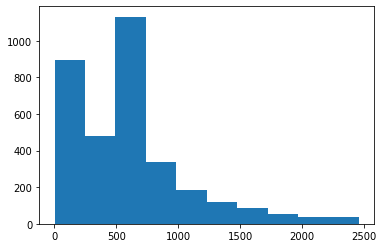

In [78]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees)
plt.show()

In [79]:
max(degrees)

2460

In [80]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[0:10]

[('salt-licker', 2460),
 ('hartator', 2449),
 ('pgodzin', 2434),
 ('victorkab', 2429),
 ('chriskanan', 2425),
 ('brianr', 2420),
 ('dford10', 2420),
 ('dlngdn', 2420),
 ('schneidmaster', 2420),
 ('ac-fd', 2420)]

In [81]:
degrees = list(filter(lambda x: x < 1000, degrees))

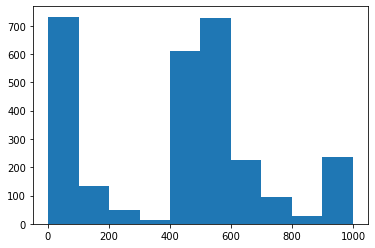

In [82]:
plt.hist(degrees)
plt.show()

## Comments count distribution

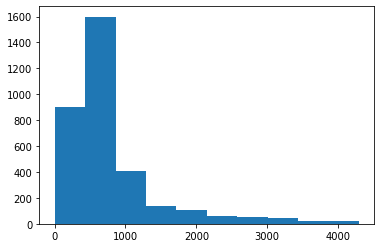

In [83]:
degrees = [G.degree(n, weight='w') for n in G.nodes()]
plt.hist(degrees)
plt.show()

In [84]:
max(degrees)

4295

In [85]:
sorted(G.degree(weight='w'), key=lambda x: x[1], reverse=True)[0:10]

[('salt-licker', 4295),
 ('pgodzin', 4253),
 ('victorkab', 4248),
 ('chriskanan', 4242),
 ('brianr', 4236),
 ('dford10', 4236),
 ('dlngdn', 4236),
 ('schneidmaster', 4236),
 ('ac-fd', 4236),
 ('kevinwuhoo', 4236)]

## Graph density

In [86]:
nx.density(G)

0.17499780993669115

## Hours histogram

In [114]:
most_active_users = sorted(G.degree(weight='w'), key=lambda x: x[1], reverse=True)[0:10]
most_active_users = list(map(lambda x: x[0], most_active_users))
most_active_users = list(map(lambda x: users[x], most_active_users))

In [118]:
hours = list(map(lambda x: list(map(lambda y: y.time.hour, x.comments)), most_active_users))
hours = [item for sublist in hours for item in sublist]
# hours = list(map(lambda x: x.time.hour, most_active_user.comments))

In [119]:
len(hours)

98

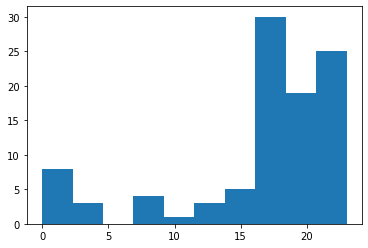

In [120]:
plt.hist(hours)
plt.show()

In [122]:
nx.pagerank(G)

1,
 'pcrivella': 0.0002573793001645862,
 'jmarks1992': 0.00026226674483775656,
 'mickael_mas': 0.00026226674483775656,
 'asarkar': 0.0004101767354993739,
 'carlreid': 0.0002714534984348532,
 'tlrobinson': 0.000569023013971213,
 'thorprichard': 0.00023091286619038372,
 'chrisquinnr': 0.00023133078847186034,
 'iopeak': 0.0005581363546624308,
 'witwiwaldo': 0.0002765863088606358,
 'nationalrobotic': 0.0009222577826342585,
 'framer': 0.00025264257450173755,
 'zwieback': 0.0002267209146581838,
 'carlsborg': 0.00014584709688995523,
 'SanderMak': 0.0002634998863912823,
 'ecjob': 0.0003425900787632055,
 'tyscorp': 0.0005479866569355038,
 'luminaobscura': 7.349431617725714e-05,
 'mcgin': 0.00025264257450173755,
 'dugjason': 0.0005593348815528468,
 'autarch': 0.00042646226472420844,
 'digitalcrafts': 0.0002336055876939931,
 'aiCeivi9': 5.170002994850085e-05,
 'gfiorav': 0.00011899276393012305,
 'longtermd': 0.00022448452742184803,
 'runemadsen': 5.980047451635648e-05,
 'mertens': 0.0002300446007